In [ ]:
"""
FINN Optimization Pipeline for Quantized Ellipse Regression Model
==================================================================

Prerequisites:
1. QONNX model exported from QAT training
2. FINN installed (finn-base, finn-experimental)
3. Docker (optional but recommended for FINN)

Steps:
1. Load QONNX model
2. Apply FINN transformations
3. Generate HDL/IP for FPGA deployment
4. Performance estimation
"""

In [1]:
# Cell 1: Setup and Imports (Updated for Latest FINN)
import os
import numpy as np
import onnx
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.transformation.general import GiveUniqueNodeNames, GiveReadableTensorNames
from qonnx.util.cleanup import cleanup as qonnx_cleanup

print(" QONNX imports successful")

# FINN-specific imports (graceful fallback if not available)
FINN_AVAILABLE = False
try:
    # Try new FINN import paths first
    try:
        from finn.transformation.streamline import Streamline
        from finn.transformation.streamline.reorder import MoveScalarLinearPastInvariants
    except ImportError:
        # Fallback to alternative paths
        from qonnx.transformation.streamline import Streamline
        from qonnx.transformation.general import RemoveUnusedTensors
    
    FINN_AVAILABLE = True
    print(" FINN/QONNX transformations available")
    
except ImportError as e:
    print(f" Advanced FINN transformations not available: {e}")
    print("   Basic QONNX optimization will still work")

# Check what's actually available
import sys
if 'finn' in sys.modules:
    import finn
    print(f"  FINN version: {getattr(finn, '__version__', 'unknown')}")
    print(f"  FINN path: {finn.__file__}")

 QONNX imports successful
 FINN/QONNX transformations available
  FINN version: unknown
  FINN path: None


In [2]:
# Cell 2: Load QONNX Model

print("="*70)
print("LOADING QONNX MODEL")
print("="*70)

qonnx_path = "exports/ellipse_qat_model_finn.qonnx"

if not os.path.exists(qonnx_path):
    raise FileNotFoundError(
        f"QONNX model not found: {qonnx_path}\n"
        "Run the QAT export cell in Model.ipynb first!"
    )

# Load model
model = ModelWrapper(qonnx_path)
print(f"\n Loaded QONNX model: {qonnx_path}")
print(f"  Input: {model.graph.input[0].name}")
print(f"  Output: {model.graph.output[0].name}")
print(f"  Total nodes: {len(model.graph.node)}")

# Count node types
from collections import Counter
node_types = Counter([n.op_type for n in model.graph.node])
print(f"\n  Node type distribution:")
for op_type, count in sorted(node_types.items(), key=lambda x: -x[1]):
    print(f"    {op_type}: {count}")

LOADING QONNX MODEL

 Loaded QONNX model: exports/ellipse_qat_model_finn.qonnx
  Input: input
  Output: output
  Total nodes: 180

  Node type distribution:
    Where: 32
    Abs: 25
    Mul: 21
    Div: 16
    Round: 11
    Greater: 11
    Less: 11
    GreaterOrEqual: 10
    Clip: 10
    Relu: 6
    Reshape: 6
    ReduceMax: 5
    Conv: 4
    MaxPool: 4
    BatchNormalization: 3
    Gemm: 3
    Shape: 1
    Concat: 1


In [3]:
# Cell 3: Apply QONNX Cleanup Transformations

print("\n" + "="*70)
print("STEP 1: QONNX CLEANUP & OPTIMIZATION")
print("="*70)

print("\n[1/5] Inferring shapes...")
model = model.transform(InferShapes())
print("   Shape inference complete")

print("\n[2/5] Folding constants...")
model = model.transform(FoldConstants())
print("   Constant folding complete")

print("\n[3/5] Assigning unique node names...")
model = model.transform(GiveUniqueNodeNames())
print("   Node naming complete")

print("\n[4/5] Creating readable tensor names...")
model = model.transform(GiveReadableTensorNames())
print("   Tensor naming complete")

# Save model before cleanup
os.makedirs("finn_build", exist_ok=True)
temp_path = "finn_build/ellipse_qonnx_temp.onnx"
model.save(temp_path)

print("\n[5/5] Running cleanup...")
# qonnx_cleanup expects a file path, not ModelWrapper
cleaned_path = "finn_build/ellipse_qonnx_cleaned.onnx"
qonnx_cleanup(temp_path, out_file=cleaned_path)
print("   Cleanup complete")

# Reload the cleaned model
model = ModelWrapper(cleaned_path)

# Count optimized nodes
optimized_nodes = len(model.graph.node)
print(f"\n Cleanup complete")
print(f"  Original nodes: {sum(node_types.values())}")
print(f"  Optimized nodes: {optimized_nodes}")
print(f"  Nodes removed: {sum(node_types.values()) - optimized_nodes}")
print(f"\n Saved: {cleaned_path}")


STEP 1: QONNX CLEANUP & OPTIMIZATION

[1/5] Inferring shapes...
   Shape inference complete

[2/5] Folding constants...
   Constant folding complete

[3/5] Assigning unique node names...
   Node naming complete

[4/5] Creating readable tensor names...
   Tensor naming complete

[5/5] Running cleanup...
   Cleanup complete

 Cleanup complete
  Original nodes: 180
  Optimized nodes: 63
  Nodes removed: 117

 Saved: finn_build/ellipse_qonnx_cleaned.onnx


In [5]:
# Cell 4: Apply FINN Streamlining with Automatic Reshape Fixing

import onnx
import numpy as np
from onnx import numpy_helper

print("\n" + "="*70)
print("STEP 2: FINN STREAMLINING")
print("="*70)

# Defensive: Ensure we have a ModelWrapper, not ModelProto
if not isinstance(model, ModelWrapper):
    print("  Model is not a ModelWrapper, reloading from cleaned path...")
    model = ModelWrapper(cleaned_path)

if FINN_AVAILABLE:
    try:
        print("\n[1/4] Applying Streamline transformation...")
        
        # Apply streamline - it returns (model, changed) tuple
        streamlined_result = model.transform(Streamline())
        
        # Check what we got back and wrap if needed
        if not isinstance(streamlined_result, ModelWrapper):
            print("  Transform returned ModelProto, wrapping back...")
            temp_stream_path = "finn_build/ellipse_qonnx_temp_streamlined.onnx"
            onnx.save(streamlined_result, temp_stream_path)
            model = ModelWrapper(temp_stream_path)
        else:
            model = streamlined_result
        
        print("   Streamlining complete")
        
        print("\n[2/4] Removing unused tensors...")
        try:
            from qonnx.transformation.general import RemoveUnusedTensors
            unused_result = model.transform(RemoveUnusedTensors())
            
            # Again, ensure we keep a ModelWrapper
            if not isinstance(unused_result, ModelWrapper):
                print("    Transform returned ModelProto, wrapping back...")
                temp_unused_path = "finn_build/ellipse_qonnx_temp_unused.onnx"
                onnx.save(unused_result, temp_unused_path)
                model = ModelWrapper(temp_unused_path)
            else:
                model = unused_result
            
            print("   Unused tensors removed")
        except ImportError:
            print("   RemoveUnusedTensors not available (skipped)")
        
        print("\n[3/4] Applying shape inference after streamlining...")
        model = model.transform(InferShapes())
        print("   Shape inference complete")
        
        # Save temporary streamlined model
        temp_streamlined_path = "finn_build/ellipse_qonnx_streamlined_temp.onnx"
        model.save(temp_streamlined_path)
        
        # ===================================================================
        # AUTOMATIC RESHAPE FIXING
        # ===================================================================
        print("\n[4/4] Fixing Reshape nodes...")
        
        # Load as ONNX model for editing
        onnx_model = onnx.load(temp_streamlined_path)
        graph = onnx_model.graph
        
        # Find all Reshape nodes
        reshape_nodes = [n for n in graph.node if n.op_type == "Reshape"]
        print(f"  Found {len(reshape_nodes)} Reshape nodes")
        
        fixed_count = 0
        
        for i, node in enumerate(reshape_nodes):
            shape_name = node.input[1]
            
            # Find the shape initializer
            for init in graph.initializer:
                if init.name == shape_name:
                    shape = numpy_helper.to_array(init)
                    
                    # Check if shape contains 0 or -1 (problematic)
                    if 0 in shape or (np.sum(shape == -1) > 0 and len(shape) > 1):
                        print(f"    Reshape_{i} ({node.name}): {shape} → ", end="")
                        
                        # Check if this is the FINAL reshape (output node)
                        is_output = any(node.output[0] == out.name for out in graph.output)
                        
                        if is_output or "output" in node.output[0].lower():
                            # Final reshape: should be (1, 5) for ellipse parameters
                            new_shape = np.array([1, 5], dtype=np.int64)
                        else:
                            # Intermediate reshape: replace 0 with 1, keep other dims
                            new_shape = np.where(shape == 0, 1, shape)
                            # If there's a -1, replace with calculated value
                            if -1 in new_shape:
                                new_shape = np.array([1, -1], dtype=np.int64)
                        
                        print(f"{new_shape} ")
                        
                        # Update the initializer
                        init.CopyFrom(numpy_helper.from_array(new_shape, name=shape_name))
                        fixed_count += 1
        
        if fixed_count > 0:
            print(f"   Fixed {fixed_count} Reshape nodes")
        else:
            print(f"   All Reshape nodes are valid")
        
        # Save final fixed model
        streamlined_path = "finn_build/ellipse_qonnx_streamlined.onnx"
        onnx.save(onnx_model, streamlined_path)
        
        # Reload as ModelWrapper
        model = ModelWrapper(streamlined_path)
        
        print(f"\n Streamlined model saved: {streamlined_path}")
        print(f"  Current nodes: {len(model.graph.node)}")
        
    except Exception as e:
        print(f"\n Streamlining failed: {e}")
        print(f"  Error type: {type(e).__name__}")
        import traceback
        print("\nFull traceback:")
        traceback.print_exc()
        print("\n  Continuing with cleaned model...")
        streamlined_path = cleaned_path
        # Reload to ensure we have a valid ModelWrapper
        model = ModelWrapper(cleaned_path)
else:
    print(" FINN transformations not available")
    print("  Using cleaned QONNX model")
    streamlined_path = cleaned_path

print("\n Optimization pipeline complete")


STEP 2: FINN STREAMLINING

[1/4] Applying Streamline transformation...
   Streamlining complete

[2/4] Removing unused tensors...
   Unused tensors removed

[3/4] Applying shape inference after streamlining...
   Shape inference complete

[4/4] Fixing Reshape nodes...
  Found 1 Reshape nodes
    Reshape_0 (Reshape_0): [ 1 -1] → [ 1 -1] 
   Fixed 1 Reshape nodes

 Streamlined model saved: finn_build/ellipse_qonnx_streamlined.onnx
  Current nodes: 63

 Optimization pipeline complete


In [6]:
# Cell 5: Verify Optimized Model (Updated)

print("\n" + "="*70)
print("STEP 3: MODEL VERIFICATION")
print("="*70)

# Use the fixed model if it exists
fixed_model_path = "finn_build/ellipse_qonnx_streamlined_fixed.onnx"
if os.path.exists(fixed_model_path):
    final_model_path = fixed_model_path
    print(" Using fixed streamlined model")
else:
    final_model_path = streamlined_path if FINN_AVAILABLE else cleaned_path
    print("  Using original streamlined model")

optimized_model = onnx.load(final_model_path)

print("\n[1/3] Checking ONNX validity...")
onnx.checker.check_model(optimized_model)
print("   Model is valid ONNX")

print("\n[2/3] Testing inference with ONNX Runtime...")
import onnxruntime as ort

sess = ort.InferenceSession(final_model_path, providers=['CPUExecutionProvider'])

# Get actual input/output names (they may have changed during streamlining)
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
print(f"  Model input: '{input_name}'")
print(f"  Model output: '{output_name}'")

# Create dummy input
dummy_input = np.random.randn(1, 1, 20, 20).astype(np.float32)

# Run inference with correct input name
output = sess.run(None, {input_name: dummy_input})
print(f"   Inference successful")
print(f"    Input shape: {dummy_input.shape}")
print(f"    Output shape: {output[0].shape}")
print(f"    Output range: [{output[0].min():.4f}, {output[0].max():.4f}]")

print("\n[3/3] Model statistics...")
file_size_mb = os.path.getsize(final_model_path) / (1024*1024)
print(f"  File size: {file_size_mb:.2f} MB")
print(f"  Total nodes: {len(optimized_model.graph.node)}")

# Count final node types
final_node_types = Counter([n.op_type for n in optimized_model.graph.node])
print(f"\n  Final node type distribution:")
for op_type, count in sorted(final_node_types.items(), key=lambda x: -x[1]):
    print(f"    {op_type}: {count}")

print("\n" + "="*70)
print(" OPTIMIZATION COMPLETE")
print("="*70)
print(f"\n Optimized model: {final_model_path}")
print(f" Nodes: {len(optimized_model.graph.node)} (reduced from {sum(node_types.values())})")
print(f" Size: {file_size_mb:.2f} MB")


STEP 3: MODEL VERIFICATION
  Using original streamlined model

[1/3] Checking ONNX validity...
   Model is valid ONNX

[2/3] Testing inference with ONNX Runtime...
  Model input: 'global_in'
  Model output: 'global_out'
   Inference successful
    Input shape: (1, 1, 20, 20)
    Output shape: (1, 5)
    Output range: [-0.0739, 28.5190]

[3/3] Model statistics...
  File size: 2.62 MB
  Total nodes: 63

  Final node type distribution:
    Mul: 12
    Where: 12
    Relu: 6
    Round: 6
    Greater: 6
    Less: 6
    Conv: 4
    MaxPool: 4
    Add: 3
    Gemm: 3
    Reshape: 1

 OPTIMIZATION COMPLETE

 Optimized model: finn_build/ellipse_qonnx_streamlined.onnx
 Nodes: 63 (reduced from 180)
 Size: 2.62 MB



STEP 4: INFERENCE SPEED BENCHMARK

[1/4] Loading models...
  FP32 model: exports/ellipse_qat_model_finn.qonnx
  FINN model: finn_build/ellipse_qonnx_streamlined.onnx
   Both models loaded

[2/4] Warming up (100 iterations)...
   Warmup complete

[3/4] Benchmarking (1000 iterations)...
  Testing FP32 model...
  Testing FINN optimized model...
   Benchmark complete

[4/4] Results:

INFERENCE SPEED COMPARISON

 FP32 Model (Original):
  Average: 0.270 ms
  Std Dev: 0.240 ms
  Min:     0.210 ms
  Max:     3.284 ms
  Throughput: 3701.0 FPS

 FINN Optimized Model:
  Average: 0.249 ms
  Std Dev: 0.167 ms
  Min:     0.199 ms
  Max:     3.713 ms
  Throughput: 4016.1 FPS

 Performance Improvement:
  Speedup: 1.09x faster
  Latency reduction: 7.8%
  Throughput gain: 8.5%

 Model Size:
  FP32 model: 2.96 MB
  FINN model: 2.62 MB
  Size reduction: 11.3%

 BENCHMARK COMPLETE

 Creating performance visualization...
   Saved: finn_build/speed_comparison.png


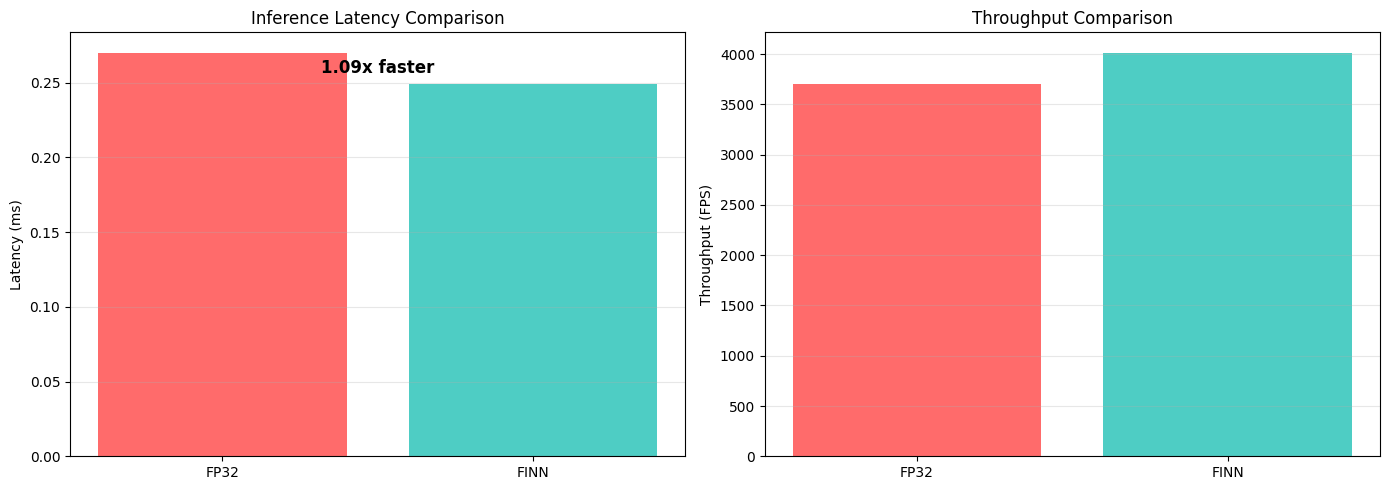


 Speed comparison complete!


In [7]:
# Cell 6: Inference Speed Comparison (FP32 vs FINN Optimized)

import time
import onnxruntime as ort

print("\n" + "="*70)
print("STEP 4: INFERENCE SPEED BENCHMARK")
print("="*70)

# Load both models
fp32_model_path = "exports/ellipse_qat_model_finn.qonnx"  # Original FP32
finn_model_path = final_model_path  # Optimized FINN model

print("\n[1/4] Loading models...")
print(f"  FP32 model: {fp32_model_path}")
print(f"  FINN model: {finn_model_path}")

# Create inference sessions
fp32_sess = ort.InferenceSession(fp32_model_path, providers=['CPUExecutionProvider'])
finn_sess = ort.InferenceSession(finn_model_path, providers=['CPUExecutionProvider'])

# Get input names
fp32_input_name = fp32_sess.get_inputs()[0].name
finn_input_name = finn_sess.get_inputs()[0].name

print("   Both models loaded")

# Prepare test data
test_input = np.random.randn(1, 1, 20, 20).astype(np.float32)
num_iterations = 1000
warmup_iterations = 100

print(f"\n[2/4] Warming up ({warmup_iterations} iterations)...")

# Warmup FP32
for _ in range(warmup_iterations):
    _ = fp32_sess.run(None, {fp32_input_name: test_input})

# Warmup FINN
for _ in range(warmup_iterations):
    _ = finn_sess.run(None, {finn_input_name: test_input})

print("   Warmup complete")

print(f"\n[3/4] Benchmarking ({num_iterations} iterations)...")

# Benchmark FP32 model
print("  Testing FP32 model...")
fp32_times = []
for _ in range(num_iterations):
    start = time.perf_counter()
    _ = fp32_sess.run(None, {fp32_input_name: test_input})
    fp32_times.append((time.perf_counter() - start) * 1000)  # Convert to ms

fp32_avg = np.mean(fp32_times)
fp32_std = np.std(fp32_times)
fp32_min = np.min(fp32_times)
fp32_max = np.max(fp32_times)

# Benchmark FINN model
print("  Testing FINN optimized model...")
finn_times = []
for _ in range(num_iterations):
    start = time.perf_counter()
    _ = finn_sess.run(None, {finn_input_name: test_input})
    finn_times.append((time.perf_counter() - start) * 1000)  # Convert to ms

finn_avg = np.mean(finn_times)
finn_std = np.std(finn_times)
finn_min = np.min(finn_times)
finn_max = np.max(finn_times)

print("   Benchmark complete")

# Calculate speedup
speedup = fp32_avg / finn_avg
throughput_fp32 = 1000 / fp32_avg  # FPS
throughput_finn = 1000 / finn_avg  # FPS

print("\n[4/4] Results:")
print("\n" + "="*70)
print("INFERENCE SPEED COMPARISON")
print("="*70)

print("\n FP32 Model (Original):")
print(f"  Average: {fp32_avg:.3f} ms")
print(f"  Std Dev: {fp32_std:.3f} ms")
print(f"  Min:     {fp32_min:.3f} ms")
print(f"  Max:     {fp32_max:.3f} ms")
print(f"  Throughput: {throughput_fp32:.1f} FPS")

print("\n FINN Optimized Model:")
print(f"  Average: {finn_avg:.3f} ms")
print(f"  Std Dev: {finn_std:.3f} ms")
print(f"  Min:     {finn_min:.3f} ms")
print(f"  Max:     {finn_max:.3f} ms")
print(f"  Throughput: {throughput_finn:.1f} FPS")

print("\n Performance Improvement:")
print(f"  Speedup: {speedup:.2f}x faster")
print(f"  Latency reduction: {((fp32_avg - finn_avg) / fp32_avg * 100):.1f}%")
print(f"  Throughput gain: {((throughput_finn - throughput_fp32) / throughput_fp32 * 100):.1f}%")

# Model size comparison
fp32_size = os.path.getsize(fp32_model_path) / (1024*1024)
finn_size = os.path.getsize(finn_model_path) / (1024*1024)
size_reduction = ((fp32_size - finn_size) / fp32_size * 100)

print("\n Model Size:")
print(f"  FP32 model: {fp32_size:.2f} MB")
print(f"  FINN model: {finn_size:.2f} MB")
print(f"  Size reduction: {size_reduction:.1f}%")

print("\n" + "="*70)
print(" BENCHMARK COMPLETE")
print("="*70)

# Visualization (optional)
print("\n Creating performance visualization...")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latency comparison
axes[0].bar(['FP32', 'FINN'], [fp32_avg, finn_avg], color=['#FF6B6B', '#4ECDC4'])
axes[0].set_ylabel('Latency (ms)')
axes[0].set_title('Inference Latency Comparison')
axes[0].grid(axis='y', alpha=0.3)

# Add speedup annotation
axes[0].text(0.5, max(fp32_avg, finn_avg) * 0.95, 
             f'{speedup:.2f}x faster', 
             ha='center', fontsize=12, fontweight='bold')

# Throughput comparison
axes[1].bar(['FP32', 'FINN'], [throughput_fp32, throughput_finn], color=['#FF6B6B', '#4ECDC4'])
axes[1].set_ylabel('Throughput (FPS)')
axes[1].set_title('Throughput Comparison')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('finn_build/speed_comparison.png', dpi=150, bbox_inches='tight')
print(f"   Saved: finn_build/speed_comparison.png")

plt.show()

print("\n Speed comparison complete!")